In [1]:
import numpy as np
import matplotlib.pyplot as plt

import healpy as hp
import nifty7 as ift

import scipy

import os
import sys
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower

#import nifty8 as ift
from scipy import interpolate
import copy

**Put the path where the software is stored** 

In [3]:
soft_path = "/home/belen/Doctorado/ML/polarizacion/inhomogeneo/soft/" #put software path

In [4]:
sys.path.append(os.path.abspath(soft_path + "source/"))

In [5]:
import utilities
import wf_noise as wf
import CG_inho

2024-11-26 19:30:56.078926: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
lmax=7000
Lsize = 20
nx = 256
d2r = np.pi/180.
dx = Lsize*d2r / float(nx) # size of pixels in radians
resolution = Lsize*60/float(nx) #arcmin
tfac = np.sqrt((dx*dx)/(nx*nx))
rad2arcmin = 180.*60./np.pi
eps_min    = 1.e-6

In [7]:
cl_ee_camb, cl_bb_camb = utilities.signal_spectrum()


**Put the path where the data and results are stored**

In [8]:
mask_mode = 1
data_folder = soft_path + "data/"
result_folder = soft_path + "results/"

if mask_mode == 0:
    sim_noise = np.load(data_folder + 'dataset_test_r01_planck1_mask1.npy')
    sim_noiseless = np.load(data_folder + 'dataset_test_noiseless_r01_planck1_mask1.npy')
else: 
    sim_noise = np.load(data_folder + 'dataset_test_r01_planck1_mask2.npy')
    sim_noiseless = np.load(data_folder + 'dataset_test_noiseless_r01_planck1_mask2.npy')


In [9]:
qobs = sim_noise[:,:,:,0]
uobs = sim_noise[:,:,:,1]
mask = sim_noise[0,:,:,2]
inho = sim_noise[0,:,:,3]
esky = sim_noiseless[:,:,:,0]
bsky = sim_noiseless[:,:,:,1]
qsky = sim_noiseless[:,:,:,2]
usky = sim_noiseless[:,:,:,3]

In [10]:
ninv_map = CG_inho.qumap(nx, dx, [ (1./inho) * np.ones( (nx,nx) ) * mask,
                       (1./inho) * np.ones( (nx,nx) ) * mask])

ninv = CG_inho.ninv_class(ninv_map, inho, lmax)

In [11]:
cls = [cl_ee_camb[:7001], cl_bb_camb[:7001]]
cl = CG_inho.spec_camb(cls)
sinv = CG_inho.sinv_class(cl, lmax)

In [12]:
Ax = CG_inho.fw_op(sinv, ninv)

In [13]:
pre_op = CG_inho.pre_op_diag(sinv, ninv)
dot_op = CG_inho.dot_op()

In [14]:
monitor = CG_inho.monitor_basic(dot_op, iter_max=np.inf, eps_min=eps_min)
criterion = monitor
tr = CG_inho.tr_cg
cache = CG_inho.cache_mem()

In [15]:
import time 

In [17]:
t0 = time.time()
pre_ops = [pre_op]
x_final = np.zeros((10,256,129,2), dtype=complex)
for i in range(len(qobs)):
    x = CG_inho.tebfft(nx,dx)
    qu_obs = CG_inho.qumap(nx, dx, [qobs[i], uobs[i]])
    b = ninv.mult_tqu(qu_obs)
    CG_inho.cd_solve(x, b, Ax, pre_ops, dot_op, criterion, tr, cache, roundoff=25)
    xefft = x.efft
    xbfft = x.bfft
    x_final[i,:,:,0] = xefft
    x_final[i,:,:,1] = xbfft
    
t1 = time.time()

print('Time to calculate the WF with CG in 10 maps (in minutes):', (t1-t0)/60)

mapas_b = np.fft.irfft2(x_final[:,:,:,1]/tfac)
mapas_e = np.fft.irfft2(x_final[:,:,:,0]/tfac)

Time to calculate the WF with CG in 10 maps (in minutes): 16.352893221378327


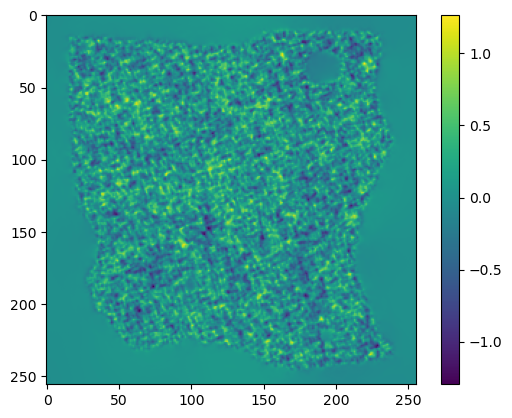

In [20]:
plt.imshow(mapas_b[1])
plt.colorbar()

In [21]:
np.save(result_folder + 'wf_CG_mapasB_planck1_eps_mask2.npy', mapas_b)
np.save(result_folder + 'wf_CG_mapasE_planck1_eps_mask2.npy', mapas_e)